In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel as parallel
import torch.distributed as distributed
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ParameterGrid
import skorch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import shap
# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster
# from dask.utils import parse_bytes
# import cudf
# import dask_cudf
# from dask_ml.preprocessing import StandardScaler
# from dask_ml.impute import SimpleImputer
# from dask_ml.wrappers import ParallelPostFit
# from dask_ml.wrappers import Incremental
# from sklearn.svm import SVC
# import cuml
from torch.nn import init
import pickle
import dask
from dask import dataframe as dd
import dask.array as da
# import dask_ml.datasets
# import dask_ml.cluster
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [2]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# cluster = LocalCUDACluster()
# client = Client(cluster)
# client

In [13]:
data = pd.read_csv("nuclear_run_on_gro_seq_capped.intersect_4DNFI18UHVRO.10kb.txt", sep = "\t")

In [14]:
data

,transcript1,expression1,transcript2,expression2,dist,norm_contacts
0,ENSG00000160072,-0.207051,ENSR00000000202,-0.100113,60000,52
1,ENSG00000224051,-0.255395,ENSR00000000202,-0.100113,230000,32
2,ENSG00000224870,0.206259,ENSR00000000202,-0.100113,150000,58
3,ENSG00000272455,-0.410519,ENSR00000000202,-0.100113,150000,58
4,ENSG00000131591,-0.185270,ENSR00000000202,-0.100113,470000,9
...,...,...,...,...,...,...
41334,ENSR00000144050,-0.100113,ENSG00000100288,0.333227,28850000,1
41335,ENSR00000144050,-0.100113,ENSG00000205559,0.058041,28850000,1
41336,ENSR00000144312,1.221681,ENSG00000008735,-0.317551,26700000,1
41337,ENSR00000144311,-0.097688,ENSG00000008735,-0.317551,26700000,1


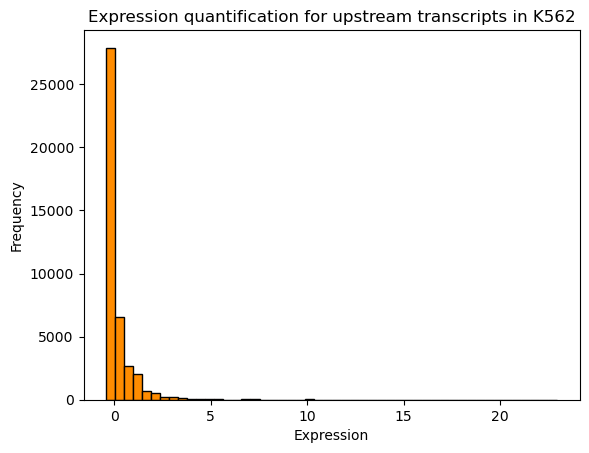

In [15]:
#Plot the distribution of the mean BioVU GREx values for transcript 1 in whole blood
plt.hist(data[['expression1']], bins=50, edgecolor='k', color='darkorange')
plt.xlabel('Expression')
plt.ylabel('Frequency')
plt.title('Expression quantification for upstream transcripts in K562')
plt.savefig("k562_expression_upstream_dist.png", dpi=300)

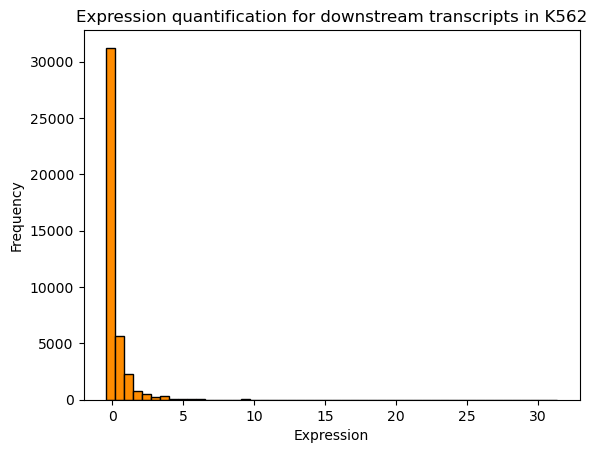

In [16]:
#Plot the distribution of the mean BioVU GREx values for transcript 2 in whole blood
plt.hist(data[['expression2']], bins=50, edgecolor='k', color='darkorange')
plt.xlabel('Expression')
plt.ylabel('Frequency')
plt.title('Expression quantification for downstream transcripts in K562')
plt.savefig("k562_expression_downstream_dist.png", dpi=300)

In [17]:
#Log1p normalized the expression values
data['expression1'] = np.log1p(data['expression1'])
data['expression2'] = np.log1p(data['expression2'])

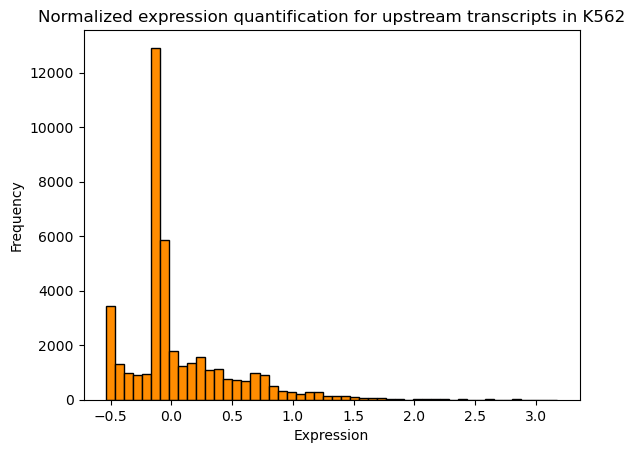

In [18]:
#Plot the distribution of the quantified expression values for transcript 1 in K562
plt.hist(data[['expression1']], bins=50, edgecolor='k', color='darkorange')
plt.xlabel('Expression')
plt.ylabel('Frequency')
plt.title('Normalized expression quantification for upstream transcripts in K562')
plt.savefig("k562_norm_expression_upstream_dist.png", dpi=300)

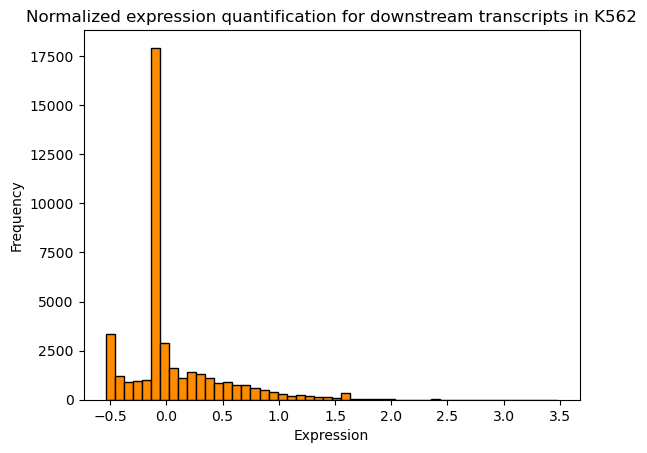

In [22]:
#Plot the distribution of the quantified expression values for transcript 2 in K562
plt.hist(data[['expression2']], bins=50, edgecolor='k', color='darkorange')
plt.xlabel('Expression')
plt.ylabel('Frequency')
plt.title('Normalized expression quantification for downstream transcripts in K562')
plt.savefig("k562_norm_expression_downstream_dist.png", dpi=300)

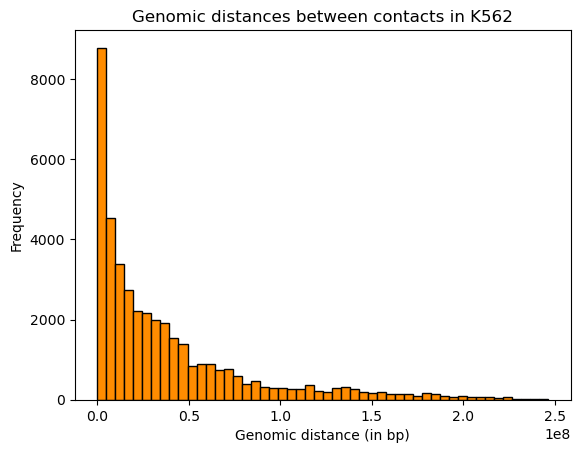

In [20]:
#Plot genomic distances in K562
plt.hist(data[['dist']], bins=50, edgecolor='k', color='darkorange')
plt.xlabel('Genomic distance (in bp)')
plt.ylabel('Frequency')
plt.title('Genomic distances between contacts in K562')
plt.savefig("k562_runon_distance_contact_dist.png", dpi=300)

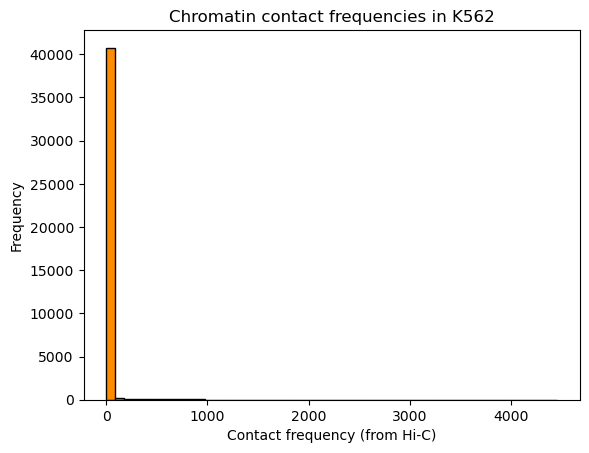

In [21]:
#Plot contact frequencies in K562
plt.hist(data[['norm_contacts']], bins=50, edgecolor='k', color='darkorange')
plt.xlabel('Contact frequency (from Hi-C)')
plt.ylabel('Frequency')
plt.title('Chromatin contact frequencies in K562')
plt.savefig("k562_runon_contact_freq.png", dpi=300)

In [12]:
#Prepare training, validation, and test data
train = data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [13]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([24803])

In [14]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([8268])

In [15]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([8268, 2])

In [16]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [17]:
torch.cuda.is_available()

True

In [48]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = NeuralNetRegressor(  #Use NeuralNetRegressor for regression
    Net,
    criterion=nn.MSELoss,  #Use Mean Squared Error loss for regression
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__num_hidden_layers=1,
    module__output_size=1,  #Output size should be 1 for regression
    verbose=False,
    device="cuda:0",
)

#Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    #'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   #scoring="neg_mean_squared_error",
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.047113 using {'module__hidden_size': 100}
0.012112 (0.003382) with: {'module__hidden_size': 10}
0.024916 (0.008498) with: {'module__hidden_size': 20}
0.035385 (0.006240) with: {'module__hidden_size': 30}
0.036887 (0.005857) with: {'module__hidden_size': 40}
0.039414 (0.007166) with: {'module__hidden_size': 50}
0.044131 (0.004982) with: {'module__hidden_size': 60}
0.043595 (0.005138) with: {'module__hidden_size': 70}
0.044313 (0.003718) with: {'module__hidden_size': 80}
0.045536 (0.004508) with: {'module__hidden_size': 90}
0.047113 (0.005002) with: {'module__hidden_size': 100}


In [49]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = NeuralNetRegressor(  #Use NeuralNetRegressor for regression
    Net,
    criterion=nn.MSELoss,  #Use Mean Squared Error loss for regression
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__num_hidden_layers=1,
    module__output_size=1,  #Output size should be 1 for regression
    verbose=False,
    device="cuda:0",
)

#Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [100, 110, 120, 130, 140, 150, 160, 170, 180],
    #'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   #scoring="neg_mean_squared_error",
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best: 0.052038 using {'module__hidden_size': 150}
0.046347 (0.005121) with: {'module__hidden_size': 100}
0.048549 (0.005907) with: {'module__hidden_size': 110}
0.049421 (0.006470) with: {'module__hidden_size': 120}
0.050185 (0.005585) with: {'module__hidden_size': 130}
0.050152 (0.005689) with: {'module__hidden_size': 140}
0.052038 (0.006071) with: {'module__hidden_size': 150}
0.050924 (0.005019) with: {'module__hidden_size': 160}
0.051066 (0.004601) with: {'module__hidden_size': 170}
0.050774 (0.005590) with: {'module__hidden_size': 180}


In [51]:
#Optimizng the number hidden layers - starting network has one hidden layer, so the actual number of hidden layers in grid search models is module__num_hidden_layers + 1
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   #scoring="neg_mean_squared_error",
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.127863 using {'module__num_hidden_layers': 2}
0.049854 (0.004134) with: {'module__num_hidden_layers': 1}
0.127863 (0.039505) with: {'module__num_hidden_layers': 2}
0.037786 (0.046697) with: {'module__num_hidden_layers': 3}
-0.000225 (0.000171) with: {'module__num_hidden_layers': 4}
-0.000262 (0.000156) with: {'module__num_hidden_layers': 5}
-0.000223 (0.000144) with: {'module__num_hidden_layers': 6}
-0.000183 (0.000155) with: {'module__num_hidden_layers': 7}
-0.000290 (0.000182) with: {'module__num_hidden_layers': 8}
-0.000269 (0.000162) with: {'module__num_hidden_layers': 9}
-0.000279 (0.000198) with: {'module__num_hidden_layers': 10}


In [52]:
#Optimizng the batch size and number of epochs
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'batch_size':[10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.168492 using {'batch_size': 100, 'max_epochs': 50}
0.073211 (0.036504) with: {'batch_size': 10, 'max_epochs': 10}
0.072307 (0.079299) with: {'batch_size': 10, 'max_epochs': 20}
0.102061 (0.069017) with: {'batch_size': 10, 'max_epochs': 30}
0.102161 (0.044782) with: {'batch_size': 10, 'max_epochs': 40}
0.080420 (0.109210) with: {'batch_size': 10, 'max_epochs': 50}
0.043551 (0.072467) with: {'batch_size': 20, 'max_epochs': 10}
0.073028 (0.058452) with: {'batch_size': 20, 'max_epochs': 20}
0.102281 (0.048760) with: {'batch_size': 20, 'max_epochs': 30}
0.117070 (0.055341) with: {'batch_size': 20, 'max_epochs': 40}
0.117088 (0.031787) with: {'batch_size': 20, 'max_epochs': 50}
0.074506 (0.045750) with: {'batch_size': 40, 'max_epochs': 10}
0.093166 (0.046357) with: {'batch_size': 40, 'max_epochs': 20}
0.096289 (0.059553) with: {'batch_size': 40, 'max_epochs': 30}
0.119147 (0.031967) with: {'batch_size': 40, 'max_epochs': 4

In [54]:
#Optimizng the batch size and number of epochs
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'batch_size':[80, 90, 100, 110, 120, 130, 140, 150],
    'max_epochs': [50, 60, 70, 80, 90, 100],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best: 0.210027 using {'batch_size': 150, 'max_epochs': 80}
0.170235 (0.038759) with: {'batch_size': 80, 'max_epochs': 50}
0.170543 (0.036434) with: {'batch_size': 80, 'max_epochs': 60}
0.146378 (0.042774) with: {'batch_size': 80, 'max_epochs': 70}
0.164410 (0.046330) with: {'batch_size': 80, 'max_epochs': 80}
0.142070 (0.046068) with: {'batch_size': 80, 'max_epochs': 90}
0.178343 (0.041203) with: {'batch_size': 80, 'max_epochs': 100}
0.170884 (0.021378) with: {'batch_size': 90, 'max_epochs': 50}
0.111479 (0.049640) with: {'batch_size': 90, 'max_epochs': 60}
0.142149 (0.058187) with: {'batch_size': 90, 'max_epochs': 70}
0.198572 (0.037205) with: {'batch_size': 90, 'max_epochs': 80}
0.190699 (0.054045) with: {'batch_size': 90, 'max_epochs': 90}
0.189115 (0.031507) with: {'batch_size': 90, 'max_epochs': 100}
0.164267 (0.044124) with: {'batch_size': 100, 'max_epochs': 50}
0.157887 (0.044285) with: {'batch_size': 100, 'max_epochs

In [55]:
#Optimizng the batch size and number of epochs
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'batch_size':[150, 160, 170, 180, 190],
    'max_epochs': [50, 60, 70, 80, 90, 100],
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.215852 using {'batch_size': 160, 'max_epochs': 90}
0.170006 (0.039461) with: {'batch_size': 150, 'max_epochs': 50}
0.165036 (0.029432) with: {'batch_size': 150, 'max_epochs': 60}
0.125048 (0.061827) with: {'batch_size': 150, 'max_epochs': 70}
0.211785 (0.068665) with: {'batch_size': 150, 'max_epochs': 80}
0.175068 (0.040292) with: {'batch_size': 150, 'max_epochs': 90}
0.197910 (0.033329) with: {'batch_size': 150, 'max_epochs': 100}
0.132478 (0.052955) with: {'batch_size': 160, 'max_epochs': 50}
0.150666 (0.008152) with: {'batch_size': 160, 'max_epochs': 60}
0.134321 (0.052007) with: {'batch_size': 160, 'max_epochs': 70}
0.188626 (0.048324) with: {'batch_size': 160, 'max_epochs': 80}
0.215852 (0.024948) with: {'batch_size': 160, 'max_epochs': 90}
0.189633 (0.026084) with: {'batch_size': 160, 'max_epochs': 100}
0.165559 (0.018945) with: {'batch_size': 170, 'max_epochs': 50}
0.187502 (0.029747) with: {'batch_size': 170,

In [56]:
#Optimizng the training optimization algorithm
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    max_epochs=90,
    batch_size=160,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__num_hidden_layers=2,
    module__output_size=1,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam],
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.002, 0.005, 0.006, 0.007, 0.008, 0.0085, 0.009, 0.01, 0.1, 0.2, 0.3]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 98 candidates, totalling 490 fits


/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/mbetti/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213,

Best: 0.222668 using {'optimizer': <class 'torch.optim.adagrad.Adagrad'>, 'optimizer__lr': 0.2}
0.030724 (0.005597) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0001}
0.046044 (0.015242) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0005}
0.055770 (0.014371) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001}
0.024172 (0.018294) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.002}
0.001609 (0.000994) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.005}
0.004442 (0.004352) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.006}
0.001656 (0.001082) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.007}
0.002581 (0.000612) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.008}
0.001291 (0.001349) with: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0085}
0.001370 (0.001444) with: {'optimizer': <class

In [57]:
#Optimizng how the weights are initialized
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adagrad,
    max_epochs=90,
    batch_size=160,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.2,
    verbose=False,
    device = "cuda:0"
)

#Define the grid of model parameters to search over
param_grid = {
    'module__weight_init_hidden': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_out': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",  # Use R2 score as the performance metric
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best: 0.229719 using {'module__weight_init_hidden': <function normal_ at 0x7f0a1327a290>, 'module__weight_init_out': <function zeros_ at 0x7f0a1327a560>}
0.012511 (0.002233) with: {'module__weight_init_hidden': <function uniform_ at 0x7f0a1327a200>, 'module__weight_init_out': <function uniform_ at 0x7f0a1327a200>}
0.029772 (0.004601) with: {'module__weight_init_hidden': <function uniform_ at 0x7f0a1327a200>, 'module__weight_init_out': <function normal_ at 0x7f0a1327a290>}
0.013496 (0.003857) with: {'module__weight_init_hidden': <function uniform_ at 0x7f0a1327a200>, 'module__weight_init_out': <function zeros_ at 0x7f0a1327a560>}
0.074928 (0.026412) with: {'module__weight_init_hidden': <function uniform_ at 0x7f0a1327a200>, 'module__weight_init_out': <function xavier_normal_ at 0x7f0a1327a830>}
0.079470 (0.030839) with: {'module__weight_init_hidden': <function uniform_ at 0x7f0a1327a200>, 'module__weight_init_out': <function 

In [63]:
#Optimizng the activation function
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    optimizer=optim.Adagrad,
    max_epochs=90,
    batch_size=160,
    module__input_size=input_shape,
    module__hidden_size=150,
    module__num_hidden_layers=2,
    module__output_size=1,
    optimizer__lr = 0.2,
    module__weight_init_hidden = init.normal_,
    module__weight_init_out = init.zeros_,
    verbose=False,
    device = "cuda:0",
    callbacks=[
        EpochScoring(scoring='r2', name='train_r2', on_train=True),
        EpochScoring(scoring='r2', name='valid_r2', on_train=False),
    ]
)

#Define the grid of model parameters to search over
param_grid = {
    'module__activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid]
}

#Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring="r2",  # Use R2 score as the performance metric
                   n_jobs=1,
                   verbose=1)

#Fit with all data
grid_result = clf.fit(X, y.float())

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best: 0.231266 using {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.000197 (0.000218) with: {'module__activation': <class 'torch.nn.modules.linear.Identity'>}
0.231266 (0.024492) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.223568 (0.027537) with: {'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
0.107810 (0.016576) with: {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
0.205842 (0.042230) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.153590 (0.027843) with: {'module__activation': <class 'torch.nn.modules.activation.GELU'>}
0.066378 (0.013891) with: {'module__activation': <class 'torch.nn.modules.activation.Softplus'>}
0.176168 (0.125196) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
0.188244 (0.094083) with: {'module__activation': <class 'torch.nn.modules.activation.Tanh'>}
0

In [60]:
# #Optimizng dropout
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, weight_constraint):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate1)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate2)
#         self.fc3 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         #Manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_out(self.fc3.weight)

#     def forward(self, x):
#         #Maxnorm weight before actual forward pass
#         with torch.no_grad():
#            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#            desired = torch.clamp(norm, max=self.weight_constraint)
#            self.fc1.weight *= (desired / norm)

#            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#            desired = torch.clamp(norm, max=self.weight_constraint)
#            self.fc2.weight *= (desired / norm)

#         x = self.activation(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.activation(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.fc3(x)
#         return x
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.Adagrad,
#     max_epochs=90,
#     batch_size=160,
#     module__input_size=input_shape,
#     module__hidden_size=150,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     optimizer__lr = 0.2,
#     module__weight_init_hidden = init.normal_,
#     module__weight_init_out = init.zeros_,
#     module__activation = nn.ReLU,
#     verbose=False,
#     device = "cuda:0",
#     callbacks=[
#         EpochScoring(scoring='r2', name='train_r2', on_train=True),
#         EpochScoring(scoring='r2', name='valid_r2', on_train=False),
#     ]
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'module__dropout_rate1': [0.0, 0.1, 0.3, 0.5],
#     'module__dropout_rate2': [0.0, 0.1, 0.3, 0.5],
#     'module__weight_constraint': [1.0, 3.0, 5.0, 7.0, 9.0]
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="r2",  # Use R^2 score as the performance metric
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# #Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [62]:
# #Optimizng L1 and L2 regularization (without dropout)
# n_cols = train_set_final.shape[1]
# input_shape = n_cols
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# #Define the neural network model
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, alpha_l1, alpha_l2):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.num_hidden_layers = num_hidden_layers - 1
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         # manually init weights
#         weight_init_hidden(self.fc1.weight)
#         for i, hidden_layer in enumerate(self.hidden_layers):
#             weight_init_hidden(hidden_layer.weight)
#         weight_init_out(self.fc2.weight)

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         for i in range(self.num_hidden_layers):
#             x = self.activation(self.hidden_layers[i](x))
#         x = self.fc2(x)
#         return x

# #Add regularization to the optimizer
# from skorch.utils import to_device
# from skorch.callbacks import Callback
# from skorch.history import History

# class RegularizationCallback(Callback):
#     def __init__(self, alpha_l1=0.01, alpha_l2=0.01, seed_value=0):
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
#         #self.seed_value = seed_value

#     def on_train_begin(self, net, X, y):
#         #torch.manual_seed(self.seed_value)
#         self.optimizer = net.optimizer_

#     def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
#         #Apply L1 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l1 * torch.sign(param.data)

#         #Apply L2 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l2 * param.data

#         #Update optimizer state with new parameter values
#         self.optimizer.state = net.optimizer_.state

#         #Add regularization loss to history
#         history = net.history
#         if 'reg_loss' not in history:
#             history.new_epoch()
#         history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
#                               self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
# model = NeuralNetRegressor(
#     Net,
#     criterion=nn.MSELoss,
#     optimizer=optim.Adagrad,
#     max_epochs=90,
#     batch_size=160,
#     module__input_size=input_shape,
#     module__hidden_size=150,
#     module__num_hidden_layers=2,
#     module__output_size=1,
#     optimizer__lr = 0.2,
#     module__weight_init_hidden = init.normal_,
#     module__weight_init_out = init.zeros_,
#     module__activation = nn.ReLU,
#     verbose=False,
#     device = "cuda:0",
#     callbacks=[
#         EpochScoring(scoring='r2', name='train_r2', on_train=True),
#         EpochScoring(scoring='r2', name='valid_r2', on_train=False),
#         RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
#     ]
# )

# #Define the grid of model parameters to search over
# param_grid = {
#     'module__alpha_l1': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
#     'module__alpha_l2': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
# }

# #Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring="r2",  # Use R^2 score as the performance metric
#                    n_jobs=1,
#                    verbose=1)

# #Fit with all data
# grid_result = clf.fit(X, y.float())

# #Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Text(0.5, 1.0, 'Training and Validation $\\mathregular{R^{2}}$')

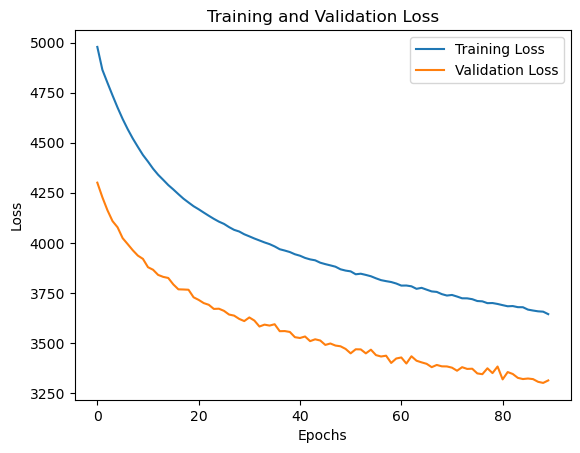

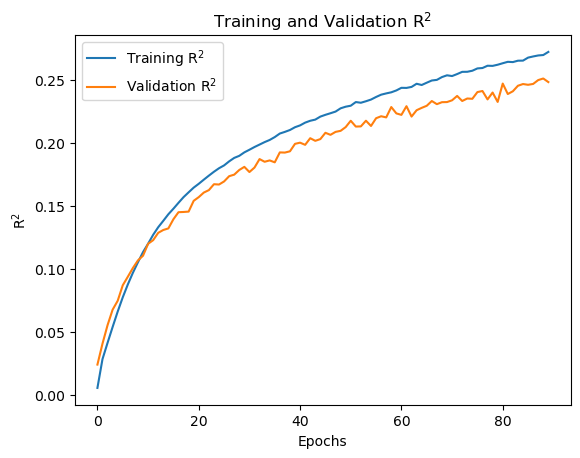

In [64]:
import matplotlib.pyplot as plt

#Get the best estimator
best_estimator = grid_result.best_estimator_
#print(best_estimator.history)

#Get training and validation loss and R2
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_r2 = best_estimator.history[:, 'train_r2']
val_r2 = best_estimator.history[:, 'valid_r2']

#Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

#Plot the training and validation R2 curves
plt.figure()
plt.plot(train_r2, label=r'Training $\mathregular{R^{2}}$')
plt.plot(val_r2, label=r'Validation $\mathregular{R^{2}}$')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel(r'$\mathregular{R^{2}}$')
plt.title(r'Training and Validation $\mathregular{R^{2}}$')

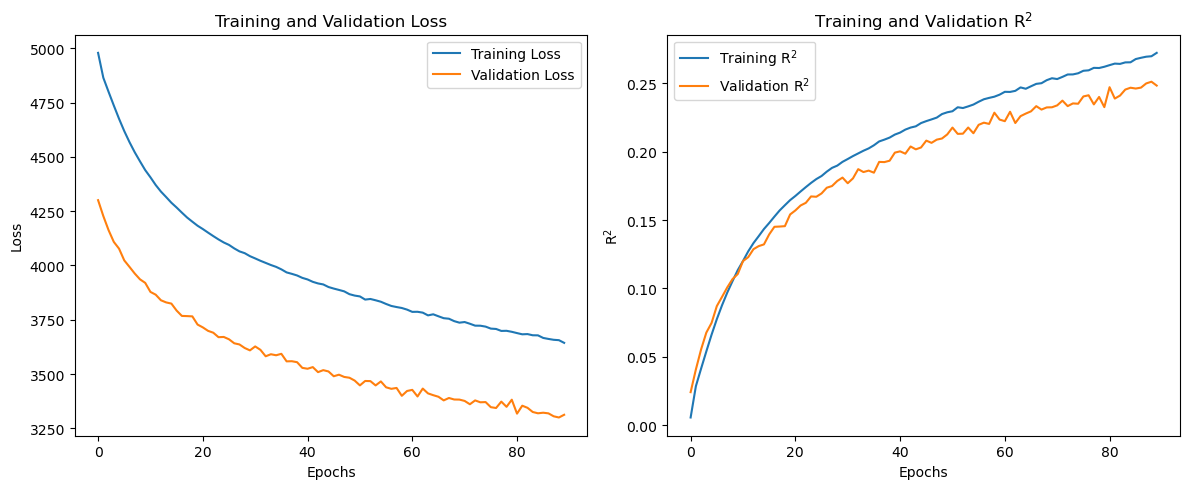

In [65]:
import matplotlib.pyplot as plt

#Get the best estimator
best_estimator = grid_result.best_estimator_

#Get training and validation loss and AUC
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_r2 = best_estimator.history[:, 'train_r2']
val_r2 = best_estimator.history[:, 'valid_r2']

#Create a figure
plt.figure(figsize=(12, 5))

#Subplot for the loss curves
plt.subplot(1, 2, 1)  #1 row, 2 columns, first plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

#Subplot for the AUC curves
plt.subplot(1, 2, 2)  #1 row, 2 columns, second plot
plt.plot(train_r2, label=r'Training $\mathregular{R^{2}}$')
plt.plot(val_r2, label=r'Validation $\mathregular{R^{2}}$')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel(r'$\mathregular{R^{2}}$')
plt.title(r'Training and Validation $\mathregular{R^{2}}$')

#Show the plots
plt.tight_layout()  #Adjusts space between plots for better layout
#plt.show()
plt.savefig("k562_nuclear_run_on_erna_gene_grex_vs_contact_freq_training_curves.png", dpi=300)

In [66]:
best_model = grid_result.best_estimator_.module_
# Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'k562_nuclear_run_on_best_contact_regression_model.h5')

In [67]:
from sklearn.metrics import r2_score

#Evaluate performance on test set
y_pred = best_model(test_set_final.to("cuda:0"))

#Compute R-squared score
r2 = r2_score(test_labels_final, y_pred.detach().cpu().numpy())

print(r2)

0.272856082289219


In [20]:
# #Surface plot
# gene1 = test_set_final.numpy()[:,0]
# gene2 = test_set_final.numpy()[:,1]
# gene1_grid, gene2_grid = np.meshgrid(gene1, gene2)

# #Convert to torch tensors
# input_data = torch.tensor(np.column_stack((gene1_grid.ravel(), gene2_grid.ravel())), dtype=torch.float32).to('cuda')

# #Get the model's predictions
# with torch.no_grad():
#     predictions_grid = best_model(input_data)
# predictions_grid = predictions_grid.cpu().numpy().reshape(gene1_grid.shape)

# #Plotting the 3D surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(gene1_grid, gene2_grid, predictions_grid, cmap='viridis')

# #Add labels and title
# ax.set_xlabel('Transcript 1 expression')
# ax.set_ylabel('Transcript 2 expression')
# ax.set_zlabel('Predicted contact frequency')
# ax.set_title('eRNA and gene expression versus predicted contact frequency')

# #Add a color bar which maps values to colors.
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# plt.show()

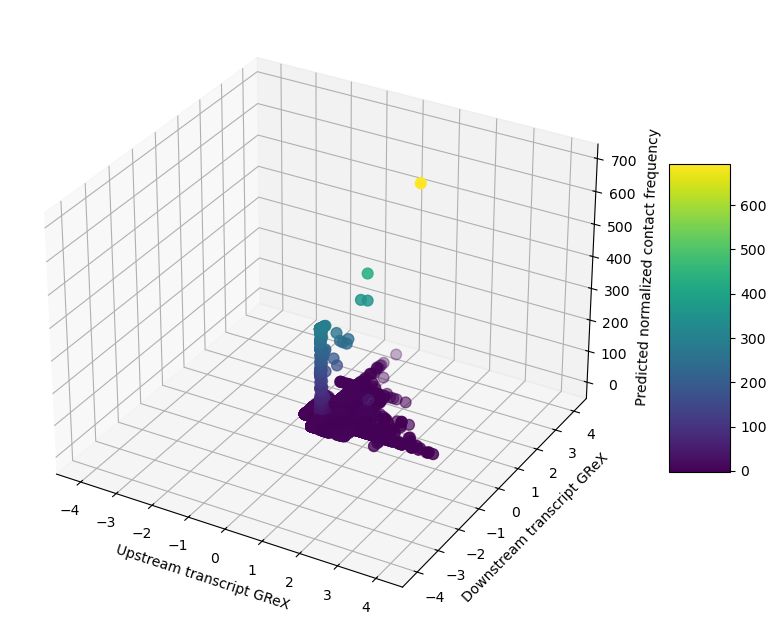

In [69]:
#Scatter plot
gene1 = test_set_final.numpy()[:,0]
gene2 = test_set_final.numpy()[:,1]
gene1_grid, gene2_grid = np.meshgrid(gene1, gene2)

#Convert to torch tensors
input_data = torch.tensor(np.column_stack((gene1_grid.ravel(), gene2_grid.ravel())), dtype=torch.float32).to('cuda:0')

#Get the model's predictions
with torch.no_grad():
    predictions = best_model(test_set_final.to('cuda:0')).cpu().numpy()

#Plotting the 3D scatter plot
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')

#Using scatter for individual points
scatter = ax.scatter(gene1, gene2, predictions, c=predictions, cmap='viridis', s=60)  #s is the size of the points

#Add labels and title
ax.set_xlabel('Upstream transcript GReX')
ax.set_ylabel('Downstream transcript GReX')
ax.set_zlabel('Predicted normalized contact frequency')
#ax.set_title('eRNA and gene genetically regulated expression versus predicted contact frequency')
ax.set_xlim([-4.5, 4.5])
ax.set_ylim([-4.5, 4.5])

#Add a color bar which maps values to colors.
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

#plt.show()
plt.savefig("k562_nuclear_run_on_erna_gene_grex_vs_contact_freq.png", dpi=300)

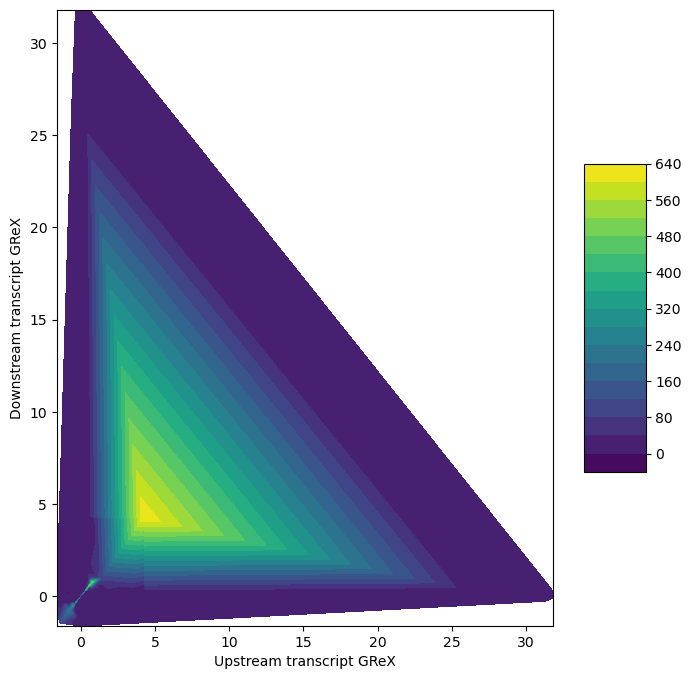

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

#Scatter plot data
gene1 = test_set_final.numpy()[:, 0]
gene2 = test_set_final.numpy()[:, 1]

#Convert to torch tensors
input_data = torch.tensor(np.column_stack((gene1, gene2)), dtype=torch.float32).to('cuda:2')

#Get the model's predictions
with torch.no_grad():
    predictions = best_model(test_set_final.to('cuda:2')).cpu().numpy()

#Remove the extra dimension from predictions
predictions = predictions.squeeze()

#Plotting the 2D contour plot
fig, ax = plt.subplots(figsize=(8, 8))

#Create a Triangulation object
triang = Triangulation(gene1, gene2)

#Using contourf for contour plot
contour = ax.tricontourf(triang, predictions, cmap='viridis', levels=20)

#Add labels and title
ax.set_xlabel('Upstream transcript GReX')
ax.set_ylabel('Downstream transcript GReX')
#ax.set_title('Contour Plot: Predicted normalized contact frequency')

#Set axis limits to include both negative and positive values
ax.set_xlim([gene1.min(), gene1.max()])
ax.set_ylim([gene2.min(), gene2.max()])

#Add a color bar which maps values to colors.
fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)

plt.savefig("whole_blood_erna_gene_grex_contour_plot.png", dpi=300)
plt.show()

In [29]:
#Testing original GReX-based model with this nuelear run-on model
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch

n_cols = train_set_final.shape[1]
input_shape = n_cols

X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0).view(-1, 1)

test_labels_final = torch.tensor(test_labels_final)

test_runon = torch.cat((X, test_set_final), axis=0)
labels_test_runon = torch.cat((y, test_labels_final.view(-1, 1)), axis=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, input_size=input_shape, hidden_size=120, output_size=1, num_hidden_layers=2, weight_init_hidden=init.kaiming_uniform_, weight_init_out=init.kaiming_normal_):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.activation = activation()
        #Manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.nn.functional.hardsigmoid(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.nn.functional.hardsigmoid(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x
    
model = Net().to(device)
model.load_state_dict(torch.load('whole_blood_best_contact_regression_model.h5', map_location=device))

from sklearn.metrics import r2_score

#Evaluate performance on test set
y_pred = model(test_runon.to("cuda:0"))

#Compute R-squared score
r2 = r2_score(labels_test_runon, y_pred.detach().cpu().numpy())
print(r2)

0.15042767774621613


/tmp/ipykernel_945999/1144014426.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_final = torch.tensor(test_labels_final)
